<a href="https://www.nvidia.com/dli"><img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/></a>

## Assessment: Building a Real-Time Video AI Application ##
In this notebook, you will utilize what you've learned in this course to complete an assessment. The assessment has been divided into a couple of steps - each of which will generate a text file for grading purposes. You will be graded based on the following rubric. Note that this coding portion does not give partial credit - it shows up as either 0 or 60 points. Earning 50 points or more will award you the full 60 points, while earning less than 50 points will award you 0 points for the coding portion. 
<table border="1" class="dataframe" align='left'>  <thead>    <tr style="text-align: right;">      <th>Step</th>      <th># of &lt;FIXME&gt;</th>      <th>Points</th>    </tr>  </thead>  <tbody>    <tr>      <td>0. The Problem</td>      <td>0</td>      <td>0</td>    </tr>    <tr>      <td>1. Understanding the Input Video</td>      <td>5</td>      <td>10</td>    </tr>    <tr>      <td>2. Brainstorm AI Inference and Download a Pre-Trained Model</td>      <td>2</td>      <td>10</td>    </tr>    <tr>      <td>3. Edit the Inference Configuration File</td>      <td>10</td>      <td>10</td>    </tr>    <tr>      <td>4. Build and Run DeepStream Pipeline</td>      <td>20</td>      <td>20</td>    </tr>    <tr>      <td>5. Analyze the Results</td>      <td>1</td>      <td>10</td>    </tr>    <tr>      <td>BONUS. Visualize Frames</td>      <td>0</td>      <td>0</td>    </tr>  </tbody></table>

<p><img src='images/iva_framework.png' width=600></p>

### Step 0: The Problem ###
You are a developer for an automobile fleet management company. You have recently installed dashboard cameras on all of the vehicles and are ready to implement AI to analyze the fleet's driving behavior. One of the issues you've noticed with the fleet is [tailgating](https://en.wikipedia.org/wiki/Tailgating), which occurs when the vehicle drives behind another vehicle without leaving sufficient distance to stop without causing a collision if the vehicle in front stops suddenly. You've decied to build a DeepStream application that will help monitor this behavior. At this point, you want to be able to log occurences of tailgating so you can understand the frequency. Note that while the input video sources are static files, the pipeline can easily be modified to consume videos in real-time. 

**Instructions**: <br>
0.1 Execute the cell to set the target video as an environment variable. <br>

In [1]:
# 0.1
# DO NOT CHANGE THIS CELL
import os
os.environ['TARGET_VIDEO_PATH']='data/assessment_stream.h264'
os.environ['TARGET_VIDEO_PATH_MP4']='data/assessment_stream.mp4'

### Step 1: Understanding the Input Video ###
The first step is to understand the properties of the input videos before we can design a system to digest them. 

Use the `ffprobe` ([see documentation if needed](https://ffmpeg.org/ffprobe.html)) command line utility to obtain the `height`, `width`, and `frame rate` of the input video. We're also using the `-hide_banner` option to minimize the text output. 

**Instructions**: <br>
1.1 Execute the cell to preview the video. <br>
1.2 Execute the cell to gather information from input video stream. <br>
1.3 Modify the `<FIXME>`s _only_ to the correct values and execute the cell to mark your answer. _You can execute this cell multiple times until satisfactory_. <br>

In [2]:
# 1.1
# DO NOT CHANGE THIS CELL
from IPython.display import Video
Video(os.environ['TARGET_VIDEO_PATH_MP4'], width=720)

In [3]:
# 1.2
# DO NOT CHANGE THIS CELL
!ffprobe -i $TARGET_VIDEO_PATH \
         -hide_banner \
         2>&1| tee my_assessment/video_profile.txt 

Input #0, h264, from 'data/assessment_stream.h264':
  Duration: N/A, bitrate: N/A
    Stream #0:0: Video: h264 (High), yuv420p(progressive), 1280x720, 59.94 fps, 59.94 tbr, 1200k tbn, 119.88 tbc


In [4]:
# 1.3
FRAME_RATE=59.94
FRAME_HEIGHT=720
FRAME_WIDTH=1280
FRAME_CODEC='h264'
FRAME_COLOR_FORMAT='yuv420p'

# DO NOT CHANGE BELOW
Answer=f"""\
FRAME RATE: {round(FRAME_RATE)} FPS \
HEIGHT: {FRAME_HEIGHT} \
WIDTH: {FRAME_WIDTH} \
FRAME_CODEC: {FRAME_CODEC} \
FRAME_COLOR_FORMAT: {FRAME_COLOR_FORMAT} \
"""

!echo $Answer > my_assessment/answer_1.txt

### Step 2: Brainstorm AI Inference and Download a Pre-Trained Model ###
The next step is to brain storm the AI inference needed to achieve the objective. For this application, we need to detect cars in the frame and identify cases when the bounding box crosses below a threshold (illustrated below). 

<p><img src='images/tailgating_logic.png' width=720></p>

Fortunately, there is a [DashCamNet](https://catalog.ngc.nvidia.com/orgs/nvidia/models/tlt_dashcamnet) purpose-built object detection model that has been trained on similar data as our video. We can use the [NGC CLI](https://ngc.nvidia.com/setup/installers/cli) to download the [DashCamNet](https://catalog.ngc.nvidia.com/orgs/nvidia/models/tlt_dashcamnet) model for our application

**Instructions**: <br>
2.1 Execute the cell to install the NGC CLI. <br>
2.2 Execute the cell to use the `ngc registry mode list` command that lists all available models. We use the `--column name`, `--column repository`, and `--column application` options to display only the relevant columns. Afterwards, review the model card for [DashCamNet](https://catalog.ngc.nvidia.com/orgs/nvidia/models/tlt_dashcamnet) and confirm that the model is fit for purpose. <br>
2.3 Update the `<FIXME>`s _only_ and execute the cell to download the [DashCamNet](https://catalog.ngc.nvidia.com/orgs/nvidia/models/tlt_dashcamnet) model. The output of the command will generate a text file for grading purposes. _You can execute this cell multiple times until satisfactory_. <br>

In [5]:
# 2.1
# DO NOT CHANGE THIS CELL
import os
os.environ['NGC_DIR']='/dli/task/ngc_assets'

%env CLI=ngccli_cat_linux.zip
!mkdir -p $NGC_DIR/ngccli
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $NGC_DIR/ngccli
!unzip -u "$NGC_DIR/ngccli/$CLI" \
       -d $NGC_DIR/ngccli/
!rm $NGC_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli/ngc-cli:{}".format(os.getenv("NGC_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_cat_linux.zip
--2022-12-24 03:07:17--  https://ngc.nvidia.com/downloads/ngccli_cat_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 18.165.83.111, 18.165.83.53, 18.165.83.119, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|18.165.83.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39230389 (37M) [application/zip]
Saving to: ‘/dli/task/ngc_assets/ngccli/ngccli_cat_linux.zip’

ngccli_cat_linux.zi 100%[===================>]  37.41M   159MB/s    in 0.2s    

2022-12-24 03:07:17 (159 MB/s) - ‘/dli/task/ngc_assets/ngccli/ngccli_cat_linux.zip’ saved [39230389/39230389]

Archive:  /dli/task/ngc_assets/ngccli/ngccli_cat_linux.zip
   creating: /dli/task/ngc_assets/ngccli/ngc-cli/
 extracting: /dli/task/ngc_assets/ngccli/ngc-cli/base_library.zip  
   creating: /dli/task/ngc_assets/ngccli/ngc-cli/jsonpickle-2.0.0.dist-info/
 extracting: /dli/task/ngc_assets/ngccli/ngc-cli/jsonpickle-2.0.0.dist-info/INSTALLER  
  inflating: /dli/task/ngc_assets/

In [6]:
# 2.2
# DO NOT CHANGE THIS CELL
!ngc registry model list nvidia/tao/* --column name --column repository --column application

[{
    "application": "Speech to Text",
    "builtBy": "aiapps",
    "createdDate": "2022-03-29T23:17:55.307Z",
    "description": "Mandarin Citrinet ASR model trained on ASR set 2.0",
    "displayName": "RIVA Citrinet ASR Mandarin",
    "framework": "Transfer Learning Toolkit",
    "isPublic": true,
    "labels": [
        {
            "key": "builtBy",
            "values": [
                "aiapps"
            ]
        },
        {
            "key": "general",
            "values": [
                "ASR",
                "NVIDIA AI Enterprise Supported",
                "TAO",
                "Riva",
                "TAO Toolkit",
                "Mandarin",
                "Citrinet",
                "NVIDIA AI"
            ]
        },
        {
            "key": "framework",
            "values": [
                "Transfer Learning Toolkit"
            ]
        },
        {
            "key": "precision",
            "values": [
                "fp16"
            ]
      

In [9]:
# 2.3
!ngc registry model download-version nvidia/tao/dashcamnet:pruned_v1.0 --dest $NGC_DIR \
2>&1| tee my_assessment/answer_2.txt

{
    "download_end": "2022-12-24 03:08:59.164343",
    "download_start": "2022-12-24 03:08:56.159823",
    "download_time": "3s",
    "files_downloaded": 3,
    "local_path": "/dli/task/ngc_assets/dashcamnet_vpruned_v1.0",
    "size_downloaded": "6.65 MB",
    "status": "Completed",
    "transfer_id": "dashcamnet_vpruned_v1.0"
}


### Step 3: Edit the Inference Configuration File ###
The next step is to modify the Gst-nvinfer configuration file that will be used to configure the AI inference plugin. You can create a new text file for this purpose manually and start from scratch or use the [template provided](spec_files/pgie_config_dashcamnet.txt). You can also refer to sample applications and configuration files [here](https://github.com/NVIDIA-AI-IOT/deepstream_python_apps). When creating the configuration file, below are the fields to pay attention to: 

Following properties are used when using TAO Toolkit models downloaded from NGC: 
* `tlt-encoded-model` - Pathname of the TAO Toolkit encoded model
* `tlt-model-key` - Model load key for the TAO Toolkit encoded model
* `labelfile-path` - Pathname of a text file containing the labels for the model
* `int8-calib-file` - Pathname of the INT8 calibration file for dynamic range adjustment with an FP32 model (only in INT8)
* `uff-input-blob-name` - Name of the input blob in the UFF file
* `output-blob-names` - Array of output layer names
* `input-dims` - Dimensions of the model as [channel; height; width; input-order] if input-order=0 i.e. NCHW
* `net-scale-factor` - Pixel normalization factor _(default=1)_

Recommended properties: 
* `batch-size` - Number of frames to be inferred together in a batch _(default=1)_

Mandatory properties for detectors: 
* `num-detected-classes` - Number of classes detected by the network

Optional properties for detectors: 
* `cluster-mode` - Clustering algorithm to use _(default=0 i.e. Group Rectangles)_
* `interval` - Number of consecutive batches to be skipped for inference _(primary mode only | default=0)_

Other optional properties: 
* `network-mode` - Data format to be used for inference _(0=FP32, 1=INT8, 2=FP16 mode | default=0 i.e. FP32)_
* `process-mode` - Mode _(primary or secondary)_ in which the plugin is to operate on _(default=1 i.e. primary)_
* `model-color-format` - Color format required by the model _(default=0 i.e. RGB)_
* `gie-unique-id` - Unique ID to be assigned to the GIE to enable the application and other elements to identify detected bounding boxes and labels _(default=0)_
* `model-engine-file` - Pathname of the serialized model engine file
* `gpu-id` - Device ID of GPU to use for pre-processing/inference _(dGPU only)_

**Note**: The values in the config file are overridden by values set through GObject properties. Another important thing to remember is that the properties recommended are specific to a primary detector, you will need to work on other properties for secondary and/or classifier. You can find most of the information needed on the [model card](https://catalog.ngc.nvidia.com/orgs/nvidia/models/tlt_dashcamnet): 

<p><img src='images/model_card.png' width=720></p>

**Instructions**: 
<br>
3.1. Open and review the [configuration file](spec_files/pgie_config_dashcamnet.txt). <br>
3.2. Update the `<FIXME>`s _only_ in the configuration file with the correct values and **save changes**. Afterwards, make sure in the cell the correct path of the configuration file is referenced and execute the cell to mark your answer. _You can execute this cell multiple times until satisfactory_. <br>

In [10]:
# 3.2
os.environ['SPEC_FILE']='/dli/task/spec_files/pgie_config_dashcamnet.txt'

# DO NOT CHANGE BELOW
!cat $SPEC_FILE
!cp -v $SPEC_FILE my_assessment/answer_3.txt

[property]
gpu-id=0
net-scale-factor=0.0039215697906911373
tlt-model-key=tlt_encode
tlt-encoded-model=/dli/task/ngc_assets/dashcamnet_vpruned_v1.0/resnet18_dashcamnet_pruned.etlt
labelfile-path=/dli/task/ngc_assets/dashcamnet_vpruned_v1.0/labels.txt
int8-calib-file=/dli/task/ngc_assets/dashcamnet_vpruned_v1.0/dashcamnet_int8.txt
input-dims=3;720;1280;0
uff-input-blob-name=input_1
batch-size=1
process-mode=1
model-color-format=0
# 0=FP32, 1=INT8, 2=FP16 mode
network-mode=0
num-detected-classes=4
interval=0
gie-unique-id=1
output-blob-names=output_bbox/BiasAdd;output_cov/Sigmoid
cluster-mode=0
'/dli/task/spec_files/pgie_config_dashcamnet.txt' -> 'my_assessment/answer_3.txt'


### Step 4: Build and Run DeepStream Pipeline ###
Next, it's time to build the pipeline. We're putting the pipeline creation and initiation procedure inside a function so it an be called easily. We also need to implement the probe callback function prior to running the pipeline. We've provided you a functional architecture and framework for this application to follow. Below is the architecture for this pipeline. 

<p><img src='images/assessment_pipeline.png' width=1080></p>

Our logic for determining if a vehicle is tailgating will be based on the coordinates of detected objects' bounding boxes shown below: 

<p><img src='images/tailgate_metrics.png' width=720></p>

While we attached the probe to the _nvdsosd_ plugin, the only requirement is that it has to be after the _nvinfer_ plugin so it contains the AI-infered metadata. Recall that we need to program the probe [callback function](https://en.wikipedia.org/wiki/Callback_(computer_programming)) to provide us a signal when tailgating is potentially occuring. The probe callback function generally follows a boilerplate, to help iterate through the batches, frames, and objects. For more information on how to implement a callback function, please refer to the [GStreamer Probe documentation](https://gstreamer.freedesktop.org/documentation/additional/design/probes.html). 

<p><img src='images/probe_boiler_plate.png' width=720></p>

We want to generate a list that will contain 0s and 1s for each frame to represent if it exhibits tailgating. Therefore there should be as many numbers as there are number of frames in the end. There should _not_ be one number associated with each object detected as it will lead to more than one number associated with each frame. Below is a sample output: 

<p><img src='images/sample_log.png' width=720></p>

**Instructions**: 
<br>
4.1. Review the pipeline architecture. <br>
4.2. Modify the `<FIXME>` _only_ in the cell with the correct code and execute the cell to define the function that will build and run the pipeline. <br>
4.3. Modify the `<FIXME>` _only_ in the cell with the correct code and execute the cell to define the probe callback function. <br>
4.4. Execute the cell to run the pipeline. <br>

In [36]:
# 4.2
#Import necessary libraries
import sys
import gi
gi.require_version('Gst', '1.0')
from gi.repository import GObject, Gst, GLib
from common.bus_call import bus_call
import pyds

def run(input_file_path):
    global inference_output
    inference_output=[]
    Gst.init(None)

    # Create element that will form a pipeline
    print("Creating Pipeline")
    pipeline=Gst.Pipeline()
    
    source=Gst.ElementFactory.make("filesrc", "file-source")
    source.set_property('location', input_file_path)
    h264parser=Gst.ElementFactory.make("h264parse", "h264-parser")
    decoder=Gst.ElementFactory.make("nvv4l2decoder", "nvv4l2-decoder")
    
    streammux=Gst.ElementFactory.make("nvstreammux", "Stream-muxer")    
    streammux.set_property('width', 1280)
    streammux.set_property('height', 720)
    streammux.set_property('batch-size', 1)
    
    pgie=Gst.ElementFactory.make('nvinfer', "primary-inference")
    pgie.set_property('config-file-path', os.environ['SPEC_FILE'])
    
    nvvidconv1=Gst.ElementFactory.make("nvvideoconvert", "convertor")
    nvosd=Gst.ElementFactory.make("nvdsosd", "onscreendisplay")
    nvvidconv2=Gst.ElementFactory.make("nvvideoconvert", "convertor2")
    capsfilter=Gst.ElementFactory.make("capsfilter", "capsfilter")
    caps=Gst.Caps.from_string("video/x-raw, format=I420")
    capsfilter.set_property("caps", caps)
    
    encoder=Gst.ElementFactory.make("avenc_mpeg4", "encoder")
    encoder.set_property("bitrate", 2000000)
    
    sink=Gst.ElementFactory.make('filesink', 'filesink')
    sink.set_property('location', 'output.mpeg4')
    sink.set_property("sync", 1)
    
    # Add the elements to the pipeline
    print("Adding elements to Pipeline")
    pipeline.add(source)
    pipeline.add(h264parser)
    pipeline.add(decoder)
    pipeline.add(streammux)
    pipeline.add(pgie)
    pipeline.add(nvvidconv1)
    pipeline.add(nvosd)
    pipeline.add(nvvidconv2)
    pipeline.add(capsfilter)
    pipeline.add(encoder)
    pipeline.add(sink)

    # Link the elements together
    print("Linking elements in the Pipeline")
    source.link(h264parser)
    h264parser.link(decoder)
    decoder.get_static_pad('src').link(streammux.get_request_pad("sink_0"))
    streammux.link(pgie)
    pgie.link(nvvidconv1)
    nvvidconv1.link(nvosd)
    nvosd.link(nvvidconv2)
    nvvidconv2.link(capsfilter)
    capsfilter.link(encoder)
    encoder.link(sink)
    
    # Attach probe to OSD sink pad
    osdsinkpad=nvosd.get_static_pad("sink")
    osdsinkpad.add_probe(Gst.PadProbeType.BUFFER, osd_sink_pad_buffer_probe, 0)

    # Create an event loop and feed gstreamer bus mesages to it
    loop=GLib.MainLoop()
    bus=pipeline.get_bus()
    bus.add_signal_watch()
    bus.connect("message", bus_call, loop)
    
    # Start play back and listen to events
    print("Starting pipeline")
    
    pipeline.set_state(Gst.State.PLAYING)
    try:
        loop.run()
    except:
        pass
    
    pipeline.set_state(Gst.State.NULL)
    return inference_output

In [49]:
# 4.3
# Define the Probe Function
def osd_sink_pad_buffer_probe(pad, info, u_data):
    gst_buffer=info.get_buffer()

    # Retrieve batch metadata from the gst_buffer
    batch_meta=pyds.gst_buffer_get_nvds_batch_meta(hash(gst_buffer))
    l_frame=batch_meta.frame_meta_list
    while l_frame is not None:
        
        # Initially set the tailgate indicator to False for each frame
        tailgate=False
        try:
            frame_meta=pyds.NvDsFrameMeta.cast(l_frame.data)
        except StopIteration:
            break
        frame_number=frame_meta.frame_num
        l_obj=frame_meta.obj_meta_list
        
        # Iterate through each object to check its dimension
        while l_obj is not None:
            try:
                obj_meta=pyds.NvDsObjectMeta.cast(l_obj.data)
                
                # If the object meet the criteria then set tailgate indicator to True
                obj_bottom=obj_meta.rect_params.top+obj_meta.rect_params.height
                #obj_right=obj_meta.rect_params.left+obj_meta.rect_params.width
                #print("obj bot:",obj_bottom,"frame height:",FRAME_HEIGHT*.9)
                if (obj_meta.rect_params.width > FRAME_WIDTH*.3) & (obj_bottom > FRAME_HEIGHT*.9): 
                    tailgate=True
                    print(tailgate)
                    
            except StopIteration:
                break
            try: 
                l_obj=l_obj.next
            except StopIteration:
                break
        
        print(f'Analyzing frame {frame_number}', end='\r')
        inference_output.append(str(int(tailgate)))
        try:
            l_frame=l_frame.next
        except StopIteration:
            break
    return Gst.PadProbeReturn.OK

In [50]:
# 4.4
tailgate_log=run(input_file_path='/dli/task/data/assessment_stream.h264')

# DO NOT CHANGE BELOW
with open('/dli/task/my_assessment/answer_4.txt', 'w') as f: 
    f.write('\n'.join(tailgate_log))

Creating Pipeline
Adding elements to Pipeline
Linking elements in the Pipeline
Starting pipeline
Trueyzing frame 925
Trueyzing frame 926
Trueyzing frame 1099
Trueyzing frame 1100
Trueyzing frame 1129
Trueyzing frame 1130
Trueyzing frame 1131
Trueyzing frame 1132
Trueyzing frame 1133
Trueyzing frame 1134
Trueyzing frame 1135
Trueyzing frame 1136
Trueyzing frame 1137
Trueyzing frame 1138
Trueyzing frame 1139
Trueyzing frame 1140
Trueyzing frame 1163
Trueyzing frame 1164
Trueyzing frame 1165
Trueyzing frame 1166
Trueyzing frame 1167
Trueyzing frame 1168
Trueyzing frame 1169
Trueyzing frame 1170
Trueyzing frame 1173
Trueyzing frame 1174
Trueyzing frame 1175
Trueyzing frame 1176
Trueyzing frame 1177
Trueyzing frame 1179
Trueyzing frame 1180
Trueyzing frame 1181
Trueyzing frame 1182
Trueyzing frame 1183
Trueyzing frame 1184
Trueyzing frame 1185
Trueyzing frame 1186
Trueyzing frame 1197
Trueyzing frame 1198
Trueyzing frame 1201
Trueyzing frame 1202
Trueyzing frame 1203
Trueyzing frame 1204
Tr

## Step 5: Analyze the Results ##
Finally, we can analyze the driving behavior using the log we've collected. 

**Instructions**: <br>
5.1. Execute the cell to import the tailgate log into a Pandas DataFrame. <br>
5.2. Execute the cell to plot the occurences of tailgating. <br>
5.3. Make sure the output `.mp4` file is being referenced and execute the cell to view the composite with the bounding boxes drawn into the original video. <br>
5.4. Execute the cell to calculate the amount of time on average this vehicle spent tailgating. <br>
5.5. Modify the `<FIXME>` _only_ to mark your answer. <br>

In [51]:
# 5.1
# DO NOT CHANGE THIS CELL
import pandas as pd

df=pd.read_csv('my_assessment/answer_4.txt', names=['inference'])
df.head()

,inference
0,0
1,0
2,0
3,0
4,0


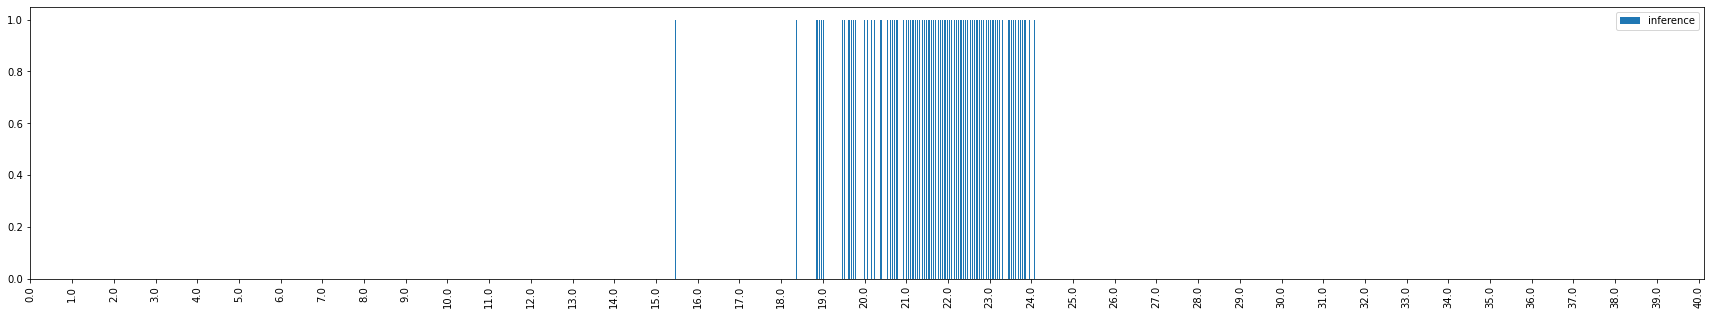

In [52]:
# 5.2
# DO NOT CHANGE THIS CELL
import matplotlib.pyplot as plt
import numpy as np

df.plot(kind='bar', figsize=(30, 5))
plt.xticks(np.arange(0, len(df)+1, FRAME_RATE), np.arange(0, len(df)/FRAME_RATE))
plt.show()

In [44]:
# 5.3
# DO NOT CHANGE THIS CELL
!ffmpeg -i output.mpeg4 output_converted.mp4 \
        -y \
        -loglevel quiet

Video('output_converted.mp4', width=720)

In [53]:
# 5.4
# DO NOT CHANGE THIS CELL
display(df['inference'].value_counts(normalize=True))

0    0.894846
1    0.105154
Name: inference, dtype: float64

In [57]:
# Question: How much time (without the percentage sign, e.g. 5.0) did the vehicle tailgate? 
Answer=df['inference'].sum()
print(Answer)
Answer = '10.5154'
# EXAMPLE: 
# Answer='5.0'

# DO NOT CHANGE BELOW
!echo $Answer > my_assessment/answer_5.txt

253


## Grade Your Code ##
If you have completed all 5 questions and confirmed the pipeline runs correctly, save changes to the notebook and revisit the webpage where you launched this interactive environment. Click on the "**ASSESS TASK**" button as shown in the screenshot below. Doing so will give you credit for this part of the lab that counts towards earning a certificate of competency for the entire course. 

<p><img src='images/credit.png' width=1080></p>

### BONUS. Visualizing Frames ###
Below we have included some helpful functions that will help you visualize the frames that exhibit tailgating behavior. 

**Instructions**: <br>
B.1. Execute the cell to extract tailgating frames. <br>
B.2. Execute the cell to display randomly selected tailgating frames. <br>

In [55]:
# B.1
# DO NOT CHANGE THIS CELL
import cv2

!mkdir output_images
!rm -r output_images/*
input_video=cv2.VideoCapture('output_converted.mp4')
retVal, im=input_video.read()
frameCount=0
while retVal:
    if frameCount in df[df['inference']==1].index:
        cv2.imwrite("output_images/frame_%d.jpg" % frameCount, im)     # save frame as JPEG file      
    retVal, im=input_video.read()
    print(f'Read a new frame: {frameCount}', end='\r')
    frameCount+=1
input_video.release()

rm: cannot remove 'output_images/*': No such file or directory


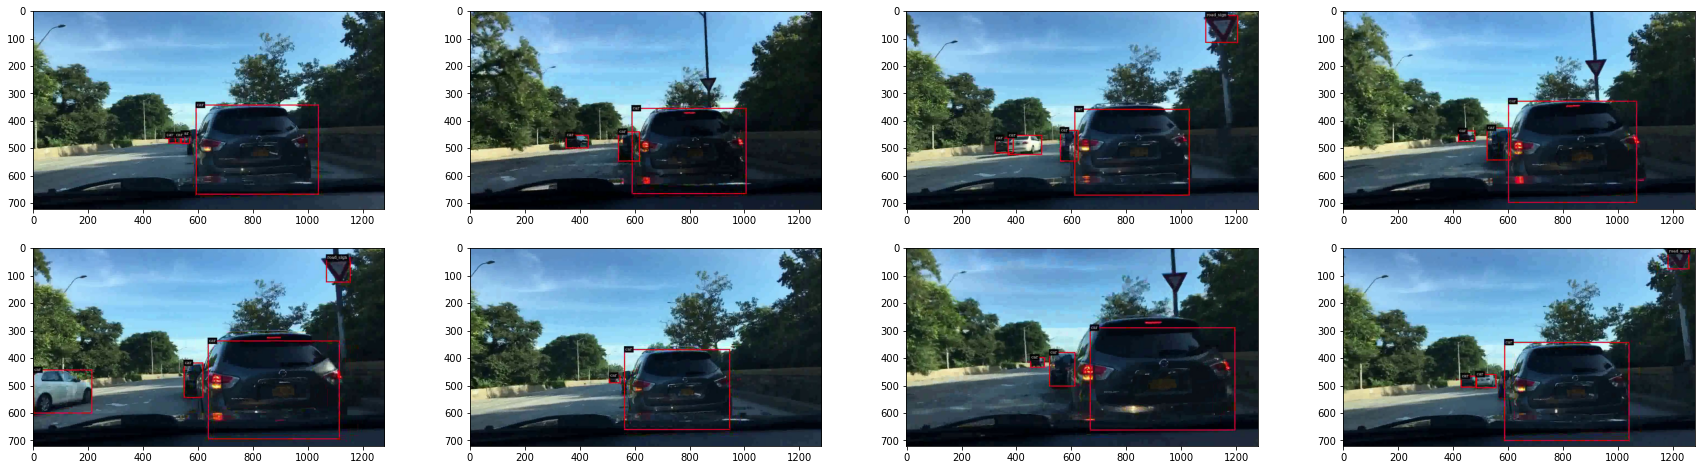

In [56]:
# B.2
# DO NOT CHANGE THIS CELL
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from matplotlib.pyplot import imshow
import numpy as np

def plot_random_samples(frames):
    sample_frames = np.random.choice(frames,size=8)
    fig=plt.figure(figsize=(30, 8))
    columns = 4
    rows = 2
    i = 1 
    for frame_num in sample_frames:
        # im = Image.open('{}/images/{}/{}.jpg'.format(config["Base_Dest_Folder"], config["Test_Video_ID"], box["frame_no"]))
        im = Image.open(f'output_images/frame_{frame_num}.jpg')
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.imshow(np.asarray(im))
    plt.show()
    
plot_random_samples(df[df['inference']==1].index)

<a href="https://www.nvidia.com/dli"><img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/></a>